# Analysis of Additional Risk Metrics for Bitcoin

## Setup

In [1]:
from matplotlib import font_manager
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Set charts theme
sns.set_theme(style="darkgrid", rc={"grid.alpha": 0.33})
plt.style.use("dark_background")

# Save chart as png function
def save_chart_as_png(filename: str) -> None:
    plt.savefig(
        f"../images/{filename}.png",
        format="png",
        dpi=300,
        orientation="landscape",
        bbox_inches="tight",
    )

In [3]:
# Get all dfs
def get_df(csv_basename: str) -> pd.DataFrame:
    # Get df from CSV with date as index
    return pd.read_csv(f"../data/{csv_basename}.csv", index_col="date", parse_dates=True)

df_btc = get_df("BTC")
df_us10y = get_df("US10Y")

## Bitcoin Yearly Risk-Adjusted Returns Over Time ⚖️

### Sharpe Ratio

In [4]:
# Get YoY returns
# Get yearly bitcoin price df with first and last prices
df_btc_yearly = df_btc.groupby(df_btc.index.year)["price"].agg(
    first_price="first",
    last_price="last",
)
# Get YoY return
df_btc_yearly["price_change"] = (df_btc_yearly["last_price"] - df_btc_yearly["first_price"]) / df_btc_yearly["first_price"]

In [5]:
# Get the volatility of monthly returns along with the number of months on yearly df
monthly_returns = df_btc["price"].resample("ME").ffill().pct_change() # Resample to monthly (month end)
monthly_stats = monthly_returns.groupby(monthly_returns.index.year).agg(
    volatility_m=("std"),
    num_months=("count"),
)
df_btc_yearly[["volatility_m", "num_months"]] = monthly_stats.reindex(df_btc_yearly.index)

In [6]:
# Get risk free rate for each year from the 10-year US treasury yield average
df_btc_yearly["us10_yield_dec_avg"] = df_us10y["yield"].groupby(df_us10y.index.year).mean() / 100

In [7]:
# Calculate Sharpe ratio, except for incomplete years (2010 and 2024)
df_btc_yearly.loc[df_btc_yearly["num_months"] == 12, "sharpe_ratio"] = round((df_btc_yearly["price_change"] - df_btc_yearly["us10_yield_dec_avg"]) / df_btc_yearly["volatility_m"], 3)

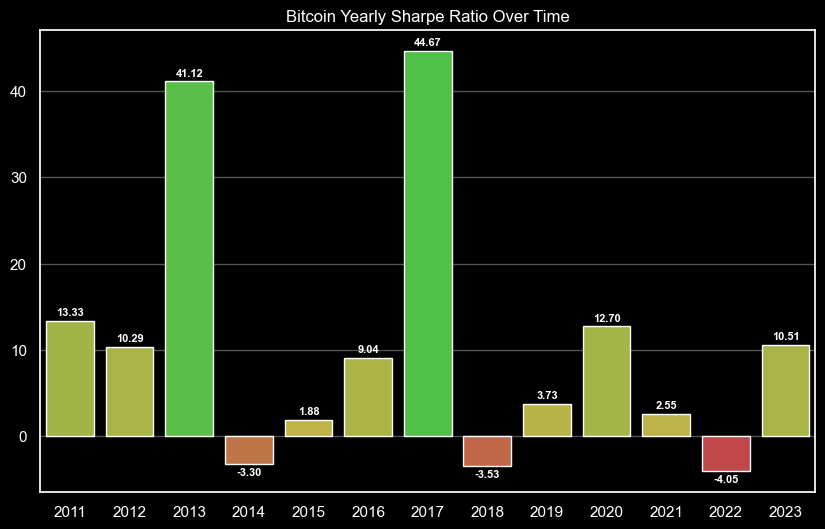

In [8]:
plt.figure(figsize=(10, 6))

# Create a custom palette for positive and negative ratios
palette_greens = LinearSegmentedColormap.from_list("positive",["#d4c334", "#40d434"])
palette_reds = LinearSegmentedColormap.from_list("negative", ["#d43438", "#d47034"])

# Get one barplot for the positive and another for the negative ratios while making sure they are in the correct order
ax = sns.barplot(data=df_btc_yearly[df_btc_yearly["sharpe_ratio"] >= 0], x="date", y="sharpe_ratio", order=df_btc_yearly[df_btc_yearly["sharpe_ratio"].notnull()].index, palette=palette_greens, hue="sharpe_ratio", legend=False)
ax = sns.barplot(data=df_btc_yearly[df_btc_yearly["sharpe_ratio"] < 0], x="date", y="sharpe_ratio", order=df_btc_yearly[df_btc_yearly["sharpe_ratio"].notnull()].index, palette=palette_reds, hue="sharpe_ratio", legend=False)

# Label each bar with its value
font_properties = font_manager.FontProperties(family="sans-serif", weight="bold", size=8)
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=2.5, fontproperties=font_properties)

plt.title("Bitcoin Yearly Sharpe Ratio Over Time")
plt.xlabel(None)
plt.ylabel(None)

save_chart_as_png("3.2_BTC_yearly_sharpe")

In [9]:
# Highest yearly Sharpe ratio
df_btc_yearly.loc[[df_btc_yearly["sharpe_ratio"].idxmax()]]

,first_price,last_price,price_change,volatility_m,num_months,us10_yield_dec_avg,sharpe_ratio
date,,,,,,,
2017,980.82475,13330.935471,12.591557,0.281342,12,0.023289,44.673


In [10]:
# Lowest yearly Sharpe ratio
df_btc_yearly.loc[[df_btc_yearly["sharpe_ratio"].idxmin()]]

,first_price,last_price,price_change,volatility_m,num_months,us10_yield_dec_avg,sharpe_ratio
date,,,,,,,
2022,46945.304437,16568.79805,-0.647062,0.16719,12,0.029529,-4.047


In [11]:
# Create table with yearly Sharpe ratios stats
pd.DataFrame({
    "Average yearly Sharpe ratio": [round(df_btc_yearly["sharpe_ratio"].mean(), 4)],
    "Median yearly Sharpe ratio": [round(df_btc_yearly["sharpe_ratio"].median(), 4)],
    "Standard deviation": [round(df_btc_yearly["sharpe_ratio"].std(), 4)],
    "Min yearly Sharpe ratio": [round(df_btc_yearly["sharpe_ratio"].min(), 4)],
    "Max yearly Sharpe ratio": [round(df_btc_yearly["sharpe_ratio"].max(), 4)],
})

,Average yearly Sharpe ratio,Median yearly Sharpe ratio,Standard deviation,Min yearly Sharpe ratio,Max yearly Sharpe ratio
0,10.6885,9.04,15.5518,-4.047,44.673


**Key takeaways:**
- Adjusting returns for risk changes the yearly rankings while preserving their sign.
- The years marked by major rallies have the best Sharpe ratio.
- Although 2017 ranks third in returns, it has the highest Sharpe ratio, slightly surpassing the "golden year".
- During bitcoin’s experimental era, returns were so high that the Sharpe ratio remained significantly elevated despite extreme volatility.
- Typically, a Sharpe ratio above 1 is considered good, but most positive years for bitcoin have exceptionally high values.
- A negative Sharpe ratio means bitcoin underperformed the risk-free asset, which only happened in years when the cryptocurrency had negative returns.
- Generally, the more negative the Sharpe ratio, the worse the performance.
- However, extreme volatility can soften the impact of a negative ratio, as seen in 2018, where volatility was higher than in 2022 but the gap between returns and the average risk-free rate was larger.

### Sortino Ratio

In [12]:
# Get the volatility of monthly negative returns on yearly df
downside_monthly_returns = monthly_returns[monthly_returns < 0]
downside_monthly_volatility = downside_monthly_returns.groupby(downside_monthly_returns.index.year).std()
df_btc_yearly["downside_volatility_m"] = downside_monthly_volatility.reindex(df_btc_yearly.index)

In [13]:
# Calculate Sortino ratio, except for incomplete years (2010 and 2024)
df_btc_yearly.loc[df_btc_yearly["num_months"] == 12, "sortino_ratio"] = round((df_btc_yearly["price_change"] - df_btc_yearly["us10_yield_dec_avg"]) / df_btc_yearly["downside_volatility_m"], 3)

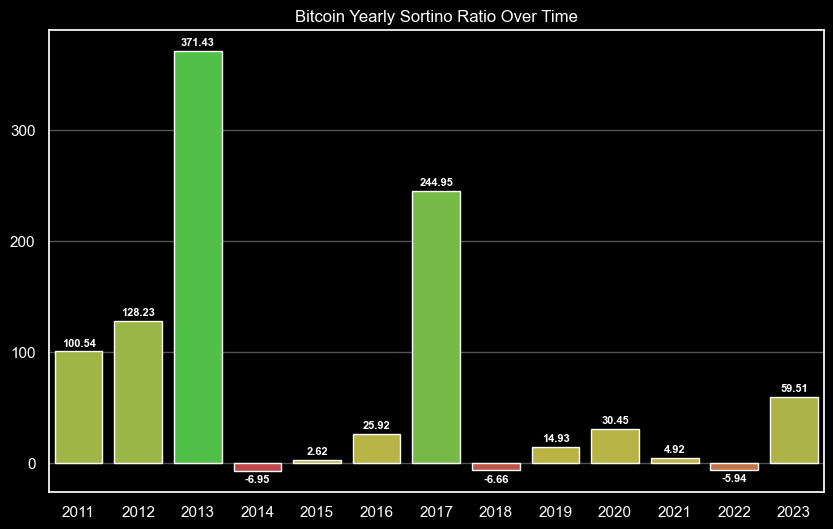

In [14]:
plt.figure(figsize=(10, 6))

# Create a custom palette for positive and negative ratios
palette_greens = LinearSegmentedColormap.from_list("positive",["#d4c334", "#40d434"])
palette_reds = LinearSegmentedColormap.from_list("negative", ["#d43438", "#d47034"])

# Get one barplot for the positive and another for the negative ratios while making sure they are in the correct order
ax = sns.barplot(data=df_btc_yearly[df_btc_yearly["sortino_ratio"] >= 0], x="date", y="sortino_ratio", order=df_btc_yearly[df_btc_yearly["sortino_ratio"].notnull()].index, palette=palette_greens, hue="sortino_ratio", legend=False)
ax = sns.barplot(data=df_btc_yearly[df_btc_yearly["sortino_ratio"] < 0], x="date", y="sortino_ratio", order=df_btc_yearly[df_btc_yearly["sortino_ratio"].notnull()].index, palette=palette_reds, hue="sortino_ratio", legend=False)

plt.yticks([0, 100, 200, 300])

# Label each bar with its value
font_properties = font_manager.FontProperties(family="sans-serif", weight="bold", size=8)
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=2.5, fontproperties=font_properties)

plt.title("Bitcoin Yearly Sortino Ratio Over Time")
plt.xlabel(None)
plt.ylabel(None)

save_chart_as_png("3.2_BTC_yearly_sortino")

In [15]:
# Highest yearly Sortino ratio
df_btc_yearly.loc[[df_btc_yearly["sortino_ratio"].idxmax()]]

,first_price,last_price,price_change,volatility_m,num_months,us10_yield_dec_avg,sharpe_ratio,downside_volatility_m,sortino_ratio
date,,,,,,,,,
2013,13.3041,753.27,55.619388,1.351998,12,0.023376,41.121,0.149682,371.428


In [16]:
# Lowest yearly Sortino ratio
df_btc_yearly.loc[[df_btc_yearly["sortino_ratio"].idxmin()]]

,first_price,last_price,price_change,volatility_m,num_months,us10_yield_dec_avg,sharpe_ratio,downside_volatility_m,sortino_ratio
date,,,,,,,,,
2014,764.1725,315.2285,-0.58749,0.185711,12,0.0253,-3.3,0.088228,-6.946


In [17]:
# Create table with yearly Sortino ratios stats
pd.DataFrame({
    "Average yearly Sortino ratio": [round(df_btc_yearly["sortino_ratio"].mean(), 4)],
    "Median yearly Sortino ratio": [round(df_btc_yearly["sortino_ratio"].median(), 4)],
    "Standard deviation": [round(df_btc_yearly["sortino_ratio"].std(), 4)],
    "Min yearly Sortino ratio": [round(df_btc_yearly["sortino_ratio"].min(), 4)],
    "Max yearly Sortino ratio": [round(df_btc_yearly["sortino_ratio"].max(), 4)],
})

,Average yearly Sortino ratio,Median yearly Sortino ratio,Standard deviation,Min yearly Sortino ratio,Max yearly Sortino ratio
0,74.1506,25.917,114.9478,-6.946,371.428


**Key takeaways:**
- When focusing on the Sortino ratio, which considers only downside volatility, there’s a noticeable shift in the absolute values across different years.
- This adjustment emphasizes the dominance of 2013, restoring it to first place, with 2017 now trailing in second.
- In 2012, downside volatility was at its lowest, and 2023 also experienced very low downside volatility, pushing these years to 3rd and 5th places, respectively.
- Ultimately, holding bitcoin for several years increases the likelihood of achieving a positive risk-adjusted return.

## Value at Risk (VaR) and Expected Shortfall (CVaR) 🚨

In [18]:
# Get log price change
df_btc["price_change_log"] = np.log(df_btc["price"] / df_btc["price"].shift(1))

In [19]:
# Calculate VaR and CVaR based for specific aggregated returns and confidence interval
def calculate_var_and_cvar(aggregated_returns: pd.Series, confidence_interval: float) -> tuple[float, float]:
    # Convert confidence interval to the corresponding percentile for VaR calculation
    percentile = (1 - confidence_interval) * 100
    
    # Calculate the historical VaR as the negative value at the specified percentile of aggregated returns
    var = -np.percentile(aggregated_returns, percentile).round(3)
    
    # Calculate CVaR as the negative mean of returns that are less than or equal to the calculated VaR
    cvar = -aggregated_returns[aggregated_returns <= -var].mean().round(3)
    
    return var, cvar

In [20]:
# Get three VaR histograms using the list of aggregated returns for each timeframe
def show_three_var_histograms(aggregated_returns_list: list[pd.Series], method: str) -> None:
    colors = ["#40e0d0", "#4067e0", "#6b40e0"]
    titles = [f"1-quater {method} Returns", f"1-year {method} Returns", f"5-year {method} Returns"]
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
    
    for i, aggregated_returns in enumerate(aggregated_returns_list):
        sns.histplot(aggregated_returns, stat="probability", binwidth=0.1, binrange=(-1, 1), color=colors[i], edgecolor="white", alpha=0.75, ax=axes[i])
        
        axes[i].axvline(np.percentile(aggregated_returns, 5), color="orange", linewidth=1.5, linestyle="--", label="VaR at 95% Confidence Level")
        axes[i].axvline(np.percentile(aggregated_returns, 1), color="red", linewidth=1.5, linestyle="--", label="VaR at 99% Confidence Level")
    
        axes[i].set_xlim(-1, 1)
        axes[i].tick_params(axis="both", labelsize=10) 
        
        axes[i].set_title(f"Distribution of the {titles[i]}")
        axes[i].set_xlabel(None)
        
    axes[0].set_ylabel("Probability")
    
    axes[1].legend(loc="upper right", fontsize=10)
    
    plt.tight_layout()

### Historical Method

In [21]:
# Get table with VaR and CVaR for a specific confidence interval for different time horizons using the historical method
time_horizons = [90, 365, 1825]
aggregated_returns_list = []
var_cvar_results = []

for time_horizon in time_horizons:
    # Calculate the rolling sum of log price changes for the specified time horizon
    aggregated_returns = df_btc["price_change_log"].rolling(window=time_horizon).sum().dropna()

    # Append aggregated returns to use in histograms
    aggregated_returns_list.append(aggregated_returns)
    
    # Calculate VaR and CVaR using the aggregated returns for 95% and 99% confidence interval
    var_95, cvar_95 = calculate_var_and_cvar(aggregated_returns, 0.95)
    var_99, cvar_99 = calculate_var_and_cvar(aggregated_returns, 0.99)
    
    # Append results to the list
    var_cvar_results.append({
        "Time Horizon": f"{time_horizon} days",
        "VaR (95%)": var_95,
        "CVaR (95%)": cvar_95,
        "VaR (99%)": var_99,
        "CVaR (99%)": cvar_99,
    })

pd.DataFrame(var_cvar_results)

,Time Horizon,VaR (95%),CVaR (95%),VaR (99%),CVaR (99%)
0,90 days,0.580,0.897,1.214,1.418
1,365 days,0.991,1.195,1.327,1.455
2,1825 days,-1.172,-0.696,-0.204,-0.069


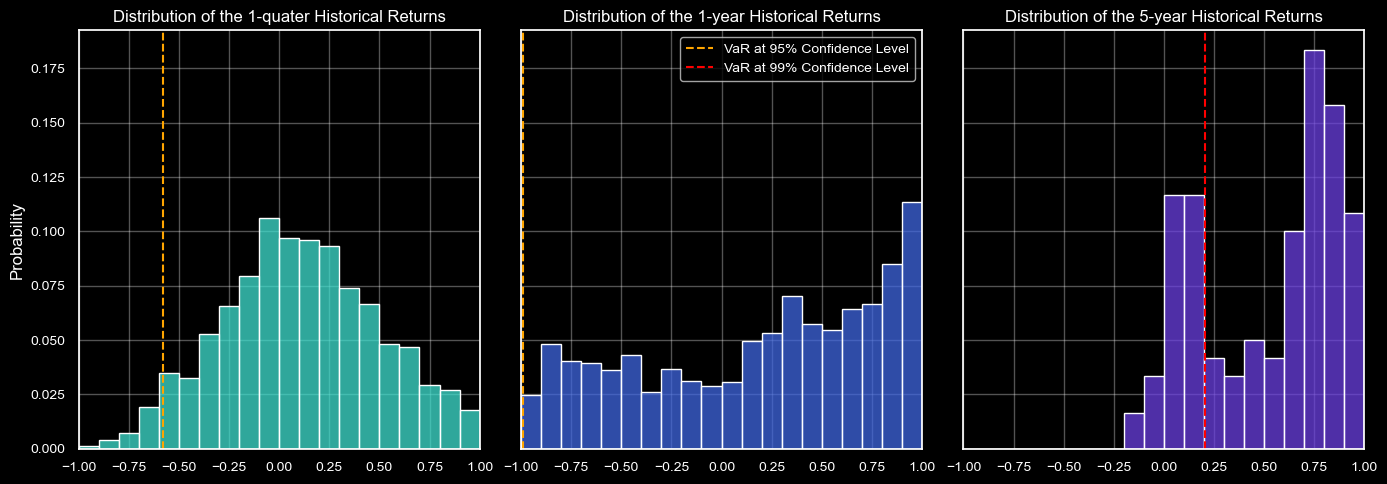

In [22]:
show_three_var_histograms(aggregated_returns_list, "Historical")

### Monte Carlo Method

In [23]:
# Get table with VaR and CVaR for a specific confidence interval for different time horizons using the Monte Carlo method
mean = df_btc["price_change_log"].mean()
std = df_btc["price_change_log"].std()
num_simulations = 10_000

time_horizons = [90, 365, 1825]
aggregated_returns_list = []
var_cvar_results = []

for time_horizon in time_horizons:
    # Simulate future returns using a normal distribution (output is array of x days by y simulations)
    simulated_returns = np.random.normal(mean, std, (num_simulations, time_horizon))
    
    # Aggregate returns over the time horizon (sum x days of each simulation)
    aggregated_returns = simulated_returns.sum(axis=1)

    # Append aggregated returns to use in histograms
    aggregated_returns_list.append(aggregated_returns)
    
    # Calculate VaR and CVaR using the aggregated returns for 95% and 99% confidence interval
    var_95, cvar_95 = calculate_var_and_cvar(aggregated_returns, 0.95)
    var_99, cvar_99 = calculate_var_and_cvar(aggregated_returns, 0.99)
    
    # Append results to the list
    var_cvar_results.append({
        "Time Horizon": f"{time_horizon} days",
        "VaR (95%)": var_95,
        "CVaR (95%)": cvar_95,
        "VaR (99%)": var_99,
        "CVaR (99%)": cvar_99,
    })

pd.DataFrame(var_cvar_results)

,Time Horizon,VaR (95%),CVaR (95%),VaR (99%),CVaR (99%)
0,90 days,0.432,0.592,0.695,0.830
1,365 days,0.354,0.714,0.923,1.210
2,1825 days,-1.984,-1.235,-0.747,-0.147


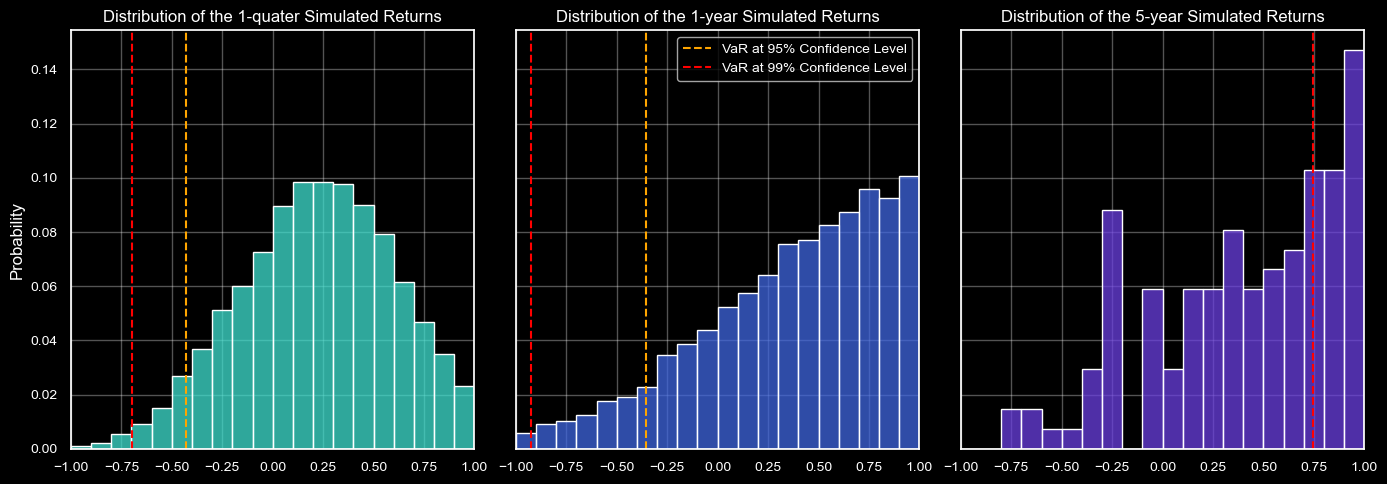

In [24]:
show_three_var_histograms(aggregated_returns_list, "Simulated")

### Monte Carlo Method (Using Values Since 2019)

In [25]:
# Get table with VaR and CVaR for a specific confidence interval for different time horizons using the Monte Carlo method
mean = df_btc[df_btc.index.year >= 2019]["price_change_log"].mean()
std = df_btc[df_btc.index.year >= 2019]["price_change_log"].std()
num_simulations = 25_000

time_horizons = [90, 365, 1825]
aggregated_returns_list = []
var_cvar_results = []

for time_horizon in time_horizons:
    # Simulate future returns using a normal distribution (output is array of x days by y simulations)
    simulated_returns = np.random.normal(mean, std, (num_simulations, time_horizon))
    
    # Aggregate returns over the time horizon (sum x days of each simulation)
    aggregated_returns = simulated_returns.sum(axis=1)

    # Append aggregated returns to use in histograms
    aggregated_returns_list.append(aggregated_returns)
    
    # Calculate VaR and CVaR using the aggregated returns for 95% and 99% confidence interval
    var_95, cvar_95 = calculate_var_and_cvar(aggregated_returns, 0.95)
    var_99, cvar_99 = calculate_var_and_cvar(aggregated_returns, 0.99)
    
    # Append results to the list
    var_cvar_results.append({
        "Time Horizon": f"{time_horizon} days",
        "VaR (95%)": var_95,
        "CVaR (95%)": cvar_95,
        "VaR (99%)": var_99,
        "CVaR (99%)": cvar_99,
    })

pd.DataFrame(var_cvar_results)

,Time Horizon,VaR (95%),CVaR (95%),VaR (99%),CVaR (99%)
0,90 days,0.264,0.362,0.425,0.500
1,365 days,0.298,0.498,0.623,0.773
2,1825 days,-0.699,-0.259,0.034,0.406


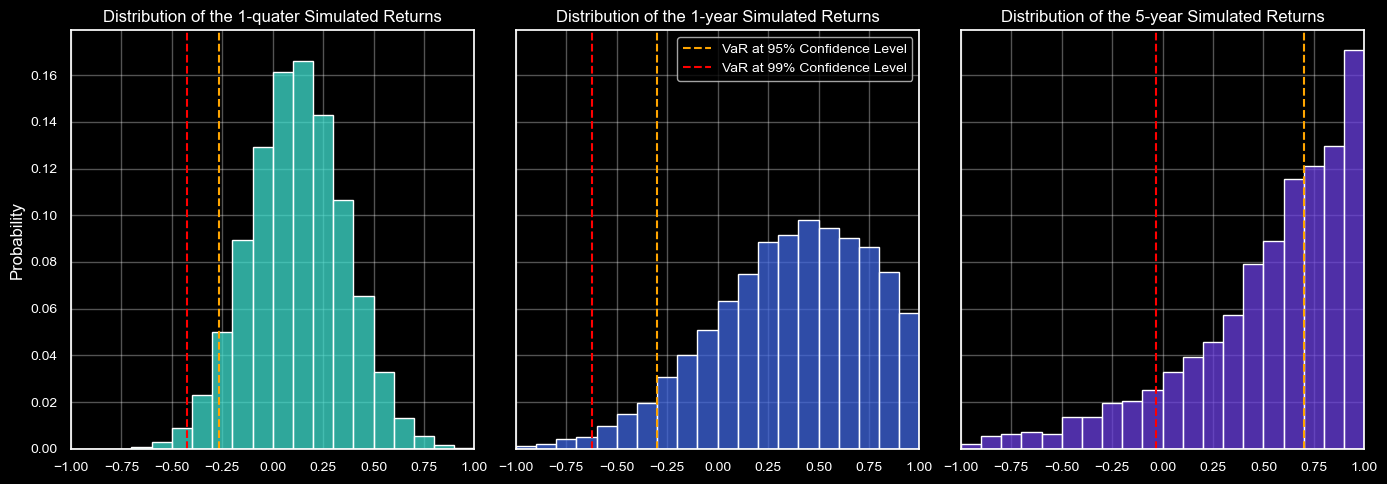

In [26]:
show_three_var_histograms(aggregated_returns_list, "Simulated")

save_chart_as_png("3.2_BTC_var")

**Key takeaways:**
- Risk should be assessed not just by volatility but also by potential losses.
- While potential losses increase slightly from a quarter to a year, they decrease significantly over a five-year horizon.
- These calculations were done using the Monte Carlo method with data from 2019, when the asset was considered more mature.
- For example, after 90 days, there is a 95% chance that the investment will retain at least 73.6% of its original value.
- Investing in bitcoin is very risky over shorter periods like a quarter or a year.
- However, with a five-year horizon, the risk significantly reduces, with a 99% chance of retaining at least 96.6% of the investment, and an expected shortfall of 40.6%.